# Lawschool DP Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def evaluate_fairness(y_true, y_pred, sensitive_features):
    """
    Evaluates fairness of the final majority vote classifier over T_inner hypotheses
    on the test set.
    #NOTE: defined in the meta_algo file, but we chose:
    a0 := African-American (COMPAS), Female (Adult)
    a1 := Caucasian (COMPAS), Male (Adult)

    :return: list. subgroups in sensitive_features.
    :return: list, dict, dict. groups is a list of the sensitive features in the dataset. 
    group_metrics is a dictionary containing dictionaries that have Delta_dp, Delta_eoy0, 
    and Delta_eoy1 for each group. gaps is a dictionary that contains the fairness gap
    for dp, eo_y0 and eo_y1.
    """
    groups = np.unique(sensitive_features.values)
    pos_count = {}
    dp_pct = {}
    eo_y0_pct = {}
    eo_y1_pct = {}

    for index, group in enumerate(groups):
        # Demographic Parity
        indices = {}
        indices[group] = sensitive_features.index[sensitive_features == group]
        dp_pct[group] = sum(y_pred[indices[group]])/len(indices[group])

        # Equalized Odds
        y1_indices = {}
        y0_indices = {}
        y1_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 1)]
        y0_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 0)]
        eo_y0_pct[group] = sum(y_pred[y0_indices[group]])/len(y0_indices[group])   
        eo_y1_pct[group] = sum(y_pred[y1_indices[group]])/len(y1_indices[group])

    gaps = {}
    group_metrics = {} # a dictionary of dictionaries

    gaps['dp'] = abs(dp_pct[groups[0]] - dp_pct[groups[1]])
    gaps['eo_y0'] = abs(eo_y0_pct[groups[0]] - eo_y0_pct[groups[1]])
    gaps['eo_y1'] = abs(eo_y1_pct[groups[0]] - eo_y1_pct[groups[1]])
    group_metrics['dp'] = dp_pct
    group_metrics['eo_y0'] = eo_y0_pct
    group_metrics['eo_y1'] = eo_y1_pct

    return groups, group_metrics, gaps

In [3]:
def set_a_indices(sensitive_features, y):
    """
    Creates a dictionary a_indices that contains the necessary information for which indices
    contain the sensitive/protected attributes.

    :return: dict 'a_indices' which contains a list of the a_0 indices, list of a_1 indices,
    list of a_0 indices where y = 0, list of a_0 indices where y = 1, list of a_1 indices
    where y = 0, list of a_1 indices where y = 1, and a list containing the a value of each sample.
    """
    a_indices = dict()
    a_indices['a0'] = sensitive_features.index[sensitive_features.eq(0)].tolist()
    a_indices['a1'] = sensitive_features.index[sensitive_features.eq(1)].tolist()
    a_indices['all'] = sensitive_features.tolist()

    y0 = set(np.where(y == 0)[0])
    y1 = set(np.where(y == 1)[0])
    a_indices['a0_y0'] = list(y0.intersection(set(a_indices['a0'])))
    a_indices['a0_y1'] = list(y1.intersection(set(a_indices['a0'])))
    a_indices['a1_y0'] = list(y0.intersection(set(a_indices['a1'])))
    a_indices['a1_y1'] = list(y1.intersection(set(a_indices['a1'])))

    assert(len(a_indices['a0']) + len(a_indices['a1']) == len(y))
    assert(len(a_indices['a0_y0']) + len(a_indices['a0_y1']) + len(a_indices['a1_y0']) + len(a_indices['a1_y1']) == len(y))
    return a_indices

def set_proportions(a_indices, y, fair_constraint):
    proportions = {}
    proportions['a0'] = len(a_indices['a0'])/float(len(y))
    proportions['a1'] = len(a_indices['a1'])/float(len(y))
    proportions['a0_y0'] = len(a_indices['a0_y0'])/float(len(y))
    proportions['a0_y1'] = len(a_indices['a0_y1'])/float(len(y))
    proportions['a1_y0'] = len(a_indices['a1_y0'])/float(len(y))
    proportions['a1_y1'] = len(a_indices['a1_y1'])/float(len(y))
    proportions['y0'] = (len(np.where(y == 0)[0]))/float(len(y))
    proportions['y1'] = (len(np.where(y == 1)[0]))/float(len(y))

    print('y0 proportion = {}'.format(proportions['y0']))
    print('y1 proportion = {}'.format(proportions['y1']))

    if(fair_constraint == 'dp'):
        print('a0 proportion = {}'.format(proportions['a0']))
        print('a1 proportion = {}'.format(proportions['a1']))
    elif(fair_constraint == 'eo'):
        print('a0 y0 proportion = {}'.format(proportions['a0_y0']))
        print('a1 y0 proportion = {}'.format(proportions['a1_y0']))
        print('a0 y1 proportion = {}'.format(proportions['a0_y1']))
        print('a1 y1 proportion = {}'.format(proportions['a1_y1']))

    assert(proportions['y0'] + proportions['y1'] == 1)
    assert(proportions['a0'] + proportions['a1'] == 1)
    #assert(proportions['a0_y0'] + proportions['a0_y1'] + proportions['a1_y0'] + proportions['a1_y1'] == 1)

    return proportions

In [4]:
def std_error(arr):
    std = np.std(arr)
    return std/np.sqrt(len(arr))

In [5]:
def confidence(arr):
    return 2.776 * std_error(arr)

## Import Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. 

In [6]:
X_train_arr = []
X_test_arr = []
y_train_arr = []
y_test_arr = []
sensitive_features_train_arr = []
sensitive_features_test_arr = []

for i in range(5):
    X_train = pd.read_csv('./../../data/processed/lawschool/lawschool_train{}_X.csv'.format(i + 1))
    X_test = pd.read_csv('./../../data/processed/lawschool/lawschool_test{}_X.csv'.format(i + 1))
    y_train = pd.read_csv('./../../data/processed/lawschool/lawschool_train{}_y.csv'.format(i + 1))
    y_test = pd.read_csv('./../../data/processed/lawschool/lawschool_test{}_y.csv'.format(i + 1))

    y_train = y_train['bar1']
    y_test = y_test['bar1']
    
    sensitive_features_train = X_train['race7']
    sensitive_features_test = X_test['race7']

    sensitive_features_train[sensitive_features_train <= 0] = 0
    sensitive_features_train[sensitive_features_train > 0] = 1
    sensitive_features_train = sensitive_features_train.reset_index(drop=True)
    
    sensitive_features_test[sensitive_features_test <= 0] = 0
    sensitive_features_test[sensitive_features_test > 0] = 1
    sensitive_features_test = sensitive_features_test.reset_index(drop=True)
    
    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)
    sensitive_features_train_arr.append(sensitive_features_train)
    sensitive_features_test_arr.append(sensitive_features_test)

In [7]:
print(X_train_arr[0].shape)
print(X_test_arr[0].shape)
print(y_train_arr[0].shape)
print(y_test_arr[0].shape)
print(len(X_train_arr))

(1458, 17)
(365, 17)
(1458,)
(365,)
5


In [8]:
a_indices_train_arr = []
a_indices_test_arr = []

for i in range(5):
    a_indices_train_arr.append(set_a_indices(sensitive_features_train_arr[i], y_train_arr[i]))
    a_indices_test_arr.append(set_a_indices(sensitive_features_test_arr[i], y_test_arr[i]))

In [9]:
proportions_train_arr = []
proportions_test_arr = []

for i in range(5):
    proportions_train_arr.append(set_proportions(a_indices_train_arr[i], y_train_arr[i], 'dp'))
    proportions_test_arr.append(set_proportions(a_indices_test_arr[i], y_test_arr[i], 'dp'))

y0 proportion = 0.46844993141289437
y1 proportion = 0.5315500685871056
a0 proportion = 0.2551440329218107
a1 proportion = 0.7448559670781894
y0 proportion = 0.5095890410958904
y1 proportion = 0.4904109589041096
a0 proportion = 0.2410958904109589
a1 proportion = 0.7589041095890411
y0 proportion = 0.47599451303155005
y1 proportion = 0.52400548696845
a0 proportion = 0.2544581618655693
a1 proportion = 0.7455418381344308
y0 proportion = 0.4794520547945205
y1 proportion = 0.5205479452054794
a0 proportion = 0.24383561643835616
a1 proportion = 0.7561643835616438
y0 proportion = 0.4725651577503429
y1 proportion = 0.5274348422496571
a0 proportion = 0.25171467764060357
a1 proportion = 0.7482853223593965
y0 proportion = 0.4931506849315068
y1 proportion = 0.5068493150684932
a0 proportion = 0.2547945205479452
a1 proportion = 0.7452054794520548
y0 proportion = 0.4670781893004115
y1 proportion = 0.5329218106995884
a0 proportion = 0.25651577503429357
a1 proportion = 0.7434842249657064
y0 proportion = 0

## Train and Predict (Unconstrained Logistic Regression)

In [10]:
unconstrained_clfrs = []
unconstrained_test_accs = []
unconstrained_dps = []
unconstrained_preds = []

In [11]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    unconstrained_logreg = LogisticRegression()

    unconstrained_logreg.fit(X_train, y_train)
    unconstrained_pred = unconstrained_logreg.predict(X_test)

    print("Adult Test Accuracy (Unconstrained, DP, Split {}): {}".format(i + 1, accuracy_score(unconstrained_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, unconstrained_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    unconstrained_clfrs.append(unconstrained_logreg)
    unconstrained_test_accs.append(accuracy_score(unconstrained_pred, y_test))
    unconstrained_dps.append(gaps['dp'])
    unconstrained_preds.append(unconstrained_pred)

Adult Test Accuracy (Unconstrained, DP, Split 1): 0.8164383561643835
P[h(X) = 1 | 0.0] = 0.19318181818181818
P[h(X) = 1 | 1.0] = 0.6101083032490975
Delta_dp = 0.4169264850672793
Adult Test Accuracy (Unconstrained, DP, Split 2): 0.7945205479452054
P[h(X) = 1 | 0.0] = 0.1797752808988764
P[h(X) = 1 | 1.0] = 0.6268115942028986
Delta_dp = 0.44703631330402216
Adult Test Accuracy (Unconstrained, DP, Split 3): 0.7890410958904109
P[h(X) = 1 | 0.0] = 0.053763440860215055
P[h(X) = 1 | 1.0] = 0.6580882352941176
Delta_dp = 0.6043247944339026
Adult Test Accuracy (Unconstrained, DP, Split 4): 0.7863013698630137
P[h(X) = 1 | 0.0] = 0.16279069767441862
P[h(X) = 1 | 1.0] = 0.6487455197132617
Delta_dp = 0.48595482203884305
Adult Test Accuracy (Unconstrained, DP, Split 5): 0.7780821917808219
P[h(X) = 1 | 0.0] = 0.1368421052631579
P[h(X) = 1 | 1.0] = 0.6444444444444445
Delta_dp = 0.5076023391812866


In [12]:
unconstrained_avg_testacc = np.mean(unconstrained_test_accs)
unconstrained_avg_dp = np.mean(unconstrained_dps)
unconstrained_test_err = std_error(unconstrained_test_accs)

## Train and Predict (Preprocessing)

In [13]:
preprocessing_clfrs = []
preprocessing_test_accs = []
preprocessing_dps = []
preprocessing_preds = []

In [14]:
# Form the IBM Fairness Dataset Object
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing

preprocess_train_arr = []

privileged_groups = [{'race7': 1}]
unprivileged_groups = [{'race7': 0}]

for s in range(5):
    X_train_copy = X_train_arr[s].copy()
    y_train_copy = y_train_arr[s].copy()
    X_test_copy = X_test_arr[s].copy()
    y_test_copy = y_test_arr[s].copy()

    X_train_copy['bar1'] = y_train_copy
    X_test_copy['bar1'] = y_test_copy
    
    preprocess_train = BinaryLabelDataset(1, 0, df=X_train_copy, label_names=['bar1'], protected_attribute_names=['race7'])
    preprocess_train_arr.append(preprocess_train)

/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py:2: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit
/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py:2: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit


In [15]:
for i in range(5):
    preprocess_train = preprocess_train_arr[i]
    
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
    dataset_transf_train = RW.fit_transform(preprocess_train)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train,
            sample_weight=dataset_transf_train.instance_weights)
    
    preprocessing_y_pred = logreg.predict(X_test)

    ### Back to using original data ###
    print("Adult Test Accuracy (Preprocessing, DP, Split {}): {}".format(i + 1, accuracy_score(preprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, preprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    preprocessing_clfrs.append(logreg)
    preprocessing_test_accs.append(accuracy_score(preprocessing_y_pred, y_test))
    preprocessing_dps.append(gaps['dp'])
    preprocessing_preds.append(preprocessing_y_pred)

Adult Test Accuracy (Preprocessing, DP, Split 1): 0.7780821917808219
P[h(X) = 1 | 0.0] = 0.4659090909090909
P[h(X) = 1 | 1.0] = 0.5523465703971119
Delta_dp = 0.086437479488021
Adult Test Accuracy (Preprocessing, DP, Split 2): 0.7479452054794521
P[h(X) = 1 | 0.0] = 0.4606741573033708
P[h(X) = 1 | 1.0] = 0.5471014492753623
Delta_dp = 0.0864272919719915
Adult Test Accuracy (Preprocessing, DP, Split 3): 0.7616438356164383
P[h(X) = 1 | 0.0] = 0.25806451612903225
P[h(X) = 1 | 1.0] = 0.5955882352941176
Delta_dp = 0.3375237191650854
Adult Test Accuracy (Preprocessing, DP, Split 4): 0.7561643835616438
P[h(X) = 1 | 0.0] = 0.3488372093023256
P[h(X) = 1 | 1.0] = 0.5304659498207885
Delta_dp = 0.18162874051846295
Adult Test Accuracy (Preprocessing, DP, Split 5): 0.7342465753424657
P[h(X) = 1 | 0.0] = 0.37894736842105264
P[h(X) = 1 | 1.0] = 0.5740740740740741
Delta_dp = 0.19512670565302143


In [16]:
preprocessing_avg_testacc = np.mean(preprocessing_test_accs)
preprocessing_avg_dp = np.mean(preprocessing_dps)
preprocessing_test_err = std_error(preprocessing_test_accs)

## Train and Predict (Inprocessing)

In [17]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

inprocessing_clfrs = []
inprocessing_test_accs = []
inprocessing_dps = []
inprocessing_preds = []

In [18]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    inprocessing_dp = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
        constraints=DemographicParity(),
        eps=0.05,
        nu=1e-6)

    inprocessing_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    inprocessing_y_pred = inprocessing_dp.predict(X_test)

    print("Adult Test Accuracy (Inprocessing, DP, Split {}): {}".format(i + 1, accuracy_score(inprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, inprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    inprocessing_clfrs.append(inprocessing_dp)
    inprocessing_test_accs.append(accuracy_score(inprocessing_y_pred, y_test))
    inprocessing_dps.append(gaps['dp'])
    inprocessing_preds.append(inprocessing_y_pred)

Adult Test Accuracy (Inprocessing, DP, Split 1): 0.7561643835616438
P[h(X) = 1 | 0.0] = 0.5113636363636364
P[h(X) = 1 | 1.0] = 0.5090252707581228
Delta_dp = 0.0023383656055135926
Adult Test Accuracy (Inprocessing, DP, Split 2): 0.7342465753424657
P[h(X) = 1 | 0.0] = 0.5617977528089888
P[h(X) = 1 | 1.0] = 0.5253623188405797
Delta_dp = 0.03643543396840909
Adult Test Accuracy (Inprocessing, DP, Split 3): 0.7452054794520548
P[h(X) = 1 | 0.0] = 0.3655913978494624
P[h(X) = 1 | 1.0] = 0.5441176470588235
Delta_dp = 0.1785262492093611
Adult Test Accuracy (Inprocessing, DP, Split 4): 0.7287671232876712
P[h(X) = 1 | 0.0] = 0.46511627906976744
P[h(X) = 1 | 1.0] = 0.5161290322580645
Delta_dp = 0.051012753188297066
Adult Test Accuracy (Inprocessing, DP, Split 5): 0.7150684931506849
P[h(X) = 1 | 0.0] = 0.47368421052631576
P[h(X) = 1 | 1.0] = 0.5444444444444444
Delta_dp = 0.07076023391812863


In [19]:
inprocessing_avg_testacc = np.mean(inprocessing_test_accs)
inprocessing_avg_dp = np.mean(inprocessing_dps)
inprocessing_test_err = std_error(inprocessing_test_accs)

## Train and Predict (Postprocessing)

In [20]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

postprocessing_clfrs = []
postprocessing_test_accs = []
postprocessing_dps = []
postprocessing_preds = []

In [21]:
class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

In [22]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    estimator_wrapper = LogisticRegressionAsRegression(logreg).fit(X_train, y_train)
    postprocessed_predictor_dp = ThresholdOptimizer(estimator=estimator_wrapper, constraints="demographic_parity", prefit=True)

    postprocessed_predictor_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    postprocessing_y_pred = postprocessed_predictor_dp.predict(X_test, sensitive_features=sensitive_features_test)

    print("Adult Test Accuracy (Postprocessing, DP): {}".format(accuracy_score(postprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)

    groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))

    postprocessing_clfrs.append(postprocessed_predictor_dp)
    postprocessing_test_accs.append(accuracy_score(postprocessing_y_pred, y_test))
    postprocessing_dps.append(gaps['dp'])
    postprocessing_preds.append(postprocessing_y_pred)

Adult Test Accuracy (Postprocessing, DP): 0.7424657534246575
P[h(X) = 1 | 0.0] = 0.4772727272727273
P[h(X) = 1 | 1.0] = 0.5018050541516246
Delta_dp = 0.02453232687889728
Adult Test Accuracy (Postprocessing, DP): 0.7315068493150685
P[h(X) = 1 | 0.0] = 0.6067415730337079
P[h(X) = 1 | 1.0] = 0.5289855072463768
Delta_dp = 0.07775606578733107
Adult Test Accuracy (Postprocessing, DP): 0.7287671232876712
P[h(X) = 1 | 0.0] = 0.46236559139784944
P[h(X) = 1 | 1.0] = 0.5772058823529411
Delta_dp = 0.11484029095509168
Adult Test Accuracy (Postprocessing, DP): 0.7013698630136986
P[h(X) = 1 | 0.0] = 0.5813953488372093
P[h(X) = 1 | 1.0] = 0.5161290322580645
Delta_dp = 0.06526631657914483
Adult Test Accuracy (Postprocessing, DP): 0.7013698630136986
P[h(X) = 1 | 0.0] = 0.5157894736842106
P[h(X) = 1 | 1.0] = 0.5555555555555556
Delta_dp = 0.039766081871345005


In [23]:
postprocessing_avg_testacc = np.mean(postprocessing_test_accs)
postprocessing_avg_dp = np.mean(postprocessing_dps)
postprocessing_test_err = std_error(postprocessing_test_accs)

## Predict (Robust Algorithm h_0, T = 1000)

In [24]:
robust_clfrs = []
robust_test_accs = []
robust_dps = []
robust_preds = []

In [25]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
        
    pickled_file = './trained_robust/ensemble_final/ensemble_final_dp_lawschoolsplit{}.pkl'.format(i+1)
    pickled_robust_h = open(pickled_file, "rb")
    robust_h = pickle.load(pickled_robust_h)
    robust_pred = robust_h.predict(X_test)
    print("Lawschool Test Accuracy (Robust, DP): {}".format(accuracy_score(robust_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, robust_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | A = {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    robust_clfrs.append(robust_h)
    robust_test_accs.append(accuracy_score(robust_pred, y_test))
    robust_dps.append(gaps['dp'])
    robust_preds.append(robust_pred)

Lawschool Test Accuracy (Robust, DP): 0.7205479452054795
P[h(X) = 1 | A = 0.0] = 0.1590909090909091
P[h(X) = 1 | A = 1.0] = 0.2924187725631769
Delta_dp = 0.1333278634722678
Lawschool Test Accuracy (Robust, DP): 0.6821917808219178
P[h(X) = 1 | A = 0.0] = 0.11235955056179775
P[h(X) = 1 | A = 1.0] = 0.2536231884057971
Delta_dp = 0.14126363784399937
Lawschool Test Accuracy (Robust, DP): 0.6493150684931507
P[h(X) = 1 | A = 0.0] = 0.043010752688172046
P[h(X) = 1 | A = 1.0] = 0.20220588235294118
Delta_dp = 0.15919512966476912
Lawschool Test Accuracy (Robust, DP): 0.6931506849315069
P[h(X) = 1 | A = 0.0] = 0.1511627906976744
P[h(X) = 1 | A = 1.0] = 0.26523297491039427
Delta_dp = 0.11407018421271986
Lawschool Test Accuracy (Robust, DP): 0.7123287671232876
P[h(X) = 1 | A = 0.0] = 0.09473684210526316
P[h(X) = 1 | A = 1.0] = 0.31851851851851853
Delta_dp = 0.22378167641325536


In [26]:
robust_avg_testacc = np.mean(robust_test_accs)
robust_avg_dp = np.mean(robust_dps)
robust_test_err = std_error(robust_test_accs)

## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [27]:
def DP_linear_prog(y_pred, a_indices, proportions, lower_bound, upper_bound, a, a_p):
    # Make sure constraint is within bounds
    assert(0 < lower_bound < 1)
    assert(0 < upper_bound < 1)
    
    # Setup variables and subgp names
    n = len(y_pred)
    w = cp.Variable(n)
    
    # Setup prediction vector
    h_xi_a = y_pred.copy()
    h_xi_a[a_indices[a_p]] = 0
    h_xi_ap = y_pred.copy()
    h_xi_ap[a_indices[a]] = 0
    
    # Setup subgroup proportions
    pi_a = proportions[a]
    pi_a_p = proportions[a_p]
    
    # Set constraints
    constraints = [
        cp.sum(w[a_indices[a]]) == pi_a,
        cp.sum(w[a_indices[a_p]]) == pi_a_p,
        cp.sum(w) == 1,
        0 <= w,
        lower_bound <= w,
        w <= upper_bound
    ]
        
    # Setup objective and problem
    objective = cp.Maximize(((1/pi_a) * (w @ h_xi_a)) - ((1/pi_a_p) * (w @ h_xi_ap)))
    problem = cp.Problem(objective, constraints)
    
    # Solve problem
    problem.solve(solver = 'ECOS')
    return problem.value, w.value

## Experiment with Linear Program (T = 1000)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [28]:
epsilon_granule = 0.01

unconstrained_objective_values = []
preprocessing_objective_values = []
inprocessing_objective_values = []
postprocessing_objective_values = []
robust_objective_values = []

# Iterate over datasets
for s in range(5):
    unconstrained_y_pred = unconstrained_preds[s]
    preprocessing_y_pred = preprocessing_preds[s]
    inprocessing_y_pred = inprocessing_preds[s]
    postprocessing_y_pred = postprocessing_preds[s]
    robust_pred = robust_preds[s]
    a_indices_test = a_indices_test_arr[s]
    proportions_test = proportions_test_arr[s]
    
    unconstrained_curr = []
    preprocessing_curr = []
    inprocessing_curr = []
    postprocessing_curr = []
    robust_curr = []
    # Iterate over constraints
    for i in range(0, int(1/epsilon_granule)):
        epsilon = epsilon_granule * i
        lower_bound = (1 - epsilon)/(len(X_test))
        upper_bound = (1 + epsilon)/(len(X_test))
        
        unconstrained_objective_value_a0a1, w = DP_linear_prog(unconstrained_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        unconstrained_objective_value_a1a0, w = DP_linear_prog(unconstrained_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        unconstrained_objective_value = max(unconstrained_objective_value_a0a1, unconstrained_objective_value_a1a0)
        unconstrained_curr.append(unconstrained_objective_value)
        
        preprocessing_objective_value_a0a1, w = DP_linear_prog(preprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        preprocessing_objective_value_a1a0, w = DP_linear_prog(preprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        preprocessing_objective_value = max(preprocessing_objective_value_a0a1, preprocessing_objective_value_a1a0)
        preprocessing_curr.append(preprocessing_objective_value)

        inprocessing_objective_value_a0a1, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        inprocessing_objective_value_a1a0, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        inprocessing_objective_value = max(inprocessing_objective_value_a0a1, inprocessing_objective_value_a1a0)
        inprocessing_curr.append(inprocessing_objective_value)

        postprocessing_objective_value_a0a1, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        postprocessing_objective_value_a1a0, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        postprocessing_objective_value = max(postprocessing_objective_value_a0a1, postprocessing_objective_value_a1a0)
        postprocessing_curr.append(postprocessing_objective_value)

        robust_objective_value_a0a1, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        robust_objective_value_a1a0, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        robust_objective_value = max(robust_objective_value_a0a1, robust_objective_value_a1a0)
        robust_curr.append(robust_objective_value)
    
    unconstrained_objective_values.append(np.asarray(unconstrained_curr))
    preprocessing_objective_values.append(np.asarray(preprocessing_curr))
    inprocessing_objective_values.append(np.asarray(inprocessing_curr))
    postprocessing_objective_values.append(np.asarray(postprocessing_curr))
    robust_objective_values.append(np.asarray(robust_curr))

In [29]:
epsilons = []
for i in range(0, int(1/epsilon_granule)):
    epsilons.append(i * epsilon_granule)

In [30]:
# Average over the results
unconstrained_avg_objective_values = np.zeros(len(unconstrained_objective_values[0]))
preprocessing_avg_objective_values = np.zeros(len(preprocessing_objective_values[0]))
inprocessing_avg_objective_values = np.zeros(len(inprocessing_objective_values[0]))
postprocessing_avg_objective_values = np.zeros(len(postprocessing_objective_values[0]))
robust_avg_objective_values = np.zeros(len(robust_objective_values[0]))

for i in range(5):
    unconstrained_avg_objective_values += unconstrained_objective_values[i]
    preprocessing_avg_objective_values += preprocessing_objective_values[i]
    inprocessing_avg_objective_values += inprocessing_objective_values[i]
    postprocessing_avg_objective_values += postprocessing_objective_values[i]
    robust_avg_objective_values += robust_objective_values[i]

unconstrained_avg_objective_values = np.divide(unconstrained_avg_objective_values, 5)
preprocessing_avg_objective_values = np.divide(preprocessing_avg_objective_values, 5)
inprocessing_avg_objective_values = np.divide(inprocessing_avg_objective_values, 5)
postprocessing_avg_objective_values = np.divide(postprocessing_avg_objective_values, 5)
robust_avg_objective_values = np.divide(robust_avg_objective_values, 5)

In [31]:
unconstrained_std_err = []
preprocessing_std_err = []
inprocessing_std_err = []
postprocessing_std_err = []
robust_std_err = []

for i in range(100):
    unconstrained_vals = []
    preprocessing_vals = []
    inprocessing_vals = []
    postprocessing_vals = []
    robust_vals = []
    
    for s in range(5):
        unconstrained_vals.append(unconstrained_objective_values[s][i])
        preprocessing_vals.append(preprocessing_objective_values[s][i])
        inprocessing_vals.append(inprocessing_objective_values[s][i])
        postprocessing_vals.append(postprocessing_objective_values[s][i])
        robust_vals.append(robust_objective_values[s][i])
        
    unconstrained_std_err.append(std_error(unconstrained_vals))
    preprocessing_std_err.append(std_error(preprocessing_vals))
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))
    robust_std_err.append(std_error(robust_vals))

In [32]:
unconstrained_conf = []
preprocessing_conf = []
inprocessing_conf = []
postprocessing_conf = []
robust_conf = []

for i in range(100):
    unconstrained_vals = []
    preprocessing_vals = []
    inprocessing_vals = []
    postprocessing_vals = []
    robust_vals = []
    
    for s in range(5):
        unconstrained_vals.append(unconstrained_objective_values[s][i])
        preprocessing_vals.append(preprocessing_objective_values[s][i])
        inprocessing_vals.append(inprocessing_objective_values[s][i])
        postprocessing_vals.append(postprocessing_objective_values[s][i])
        robust_vals.append(robust_objective_values[s][i])
        
    unconstrained_conf.append(confidence(unconstrained_vals))
    preprocessing_conf.append(confidence(preprocessing_vals))
    inprocessing_conf.append(confidence(inprocessing_vals))
    postprocessing_conf.append(confidence(postprocessing_vals))
    robust_conf.append(confidence(robust_vals))

Text(0.5, 1.0, 'Lawschool Comparison (DP)')

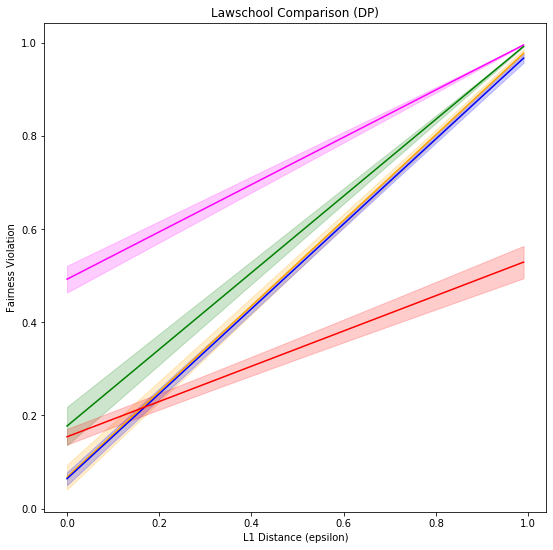

In [33]:
# Plot the constraints vs. objective values
fig = plt.figure(figsize=(9,9))
plt.plot(epsilons, unconstrained_avg_objective_values, 'magenta')
plt.plot(epsilons, preprocessing_avg_objective_values, 'green')
plt.plot(epsilons, inprocessing_avg_objective_values, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values, 'blue')
plt.plot(epsilons, robust_avg_objective_values, 'red')
plt.fill_between(epsilons, unconstrained_avg_objective_values - unconstrained_std_err, unconstrained_avg_objective_values + unconstrained_std_err, color='magenta', alpha=0.2)
plt.fill_between(epsilons, preprocessing_avg_objective_values - preprocessing_std_err, preprocessing_avg_objective_values + preprocessing_std_err, color='green', alpha=0.2)
plt.fill_between(epsilons, inprocessing_avg_objective_values - inprocessing_std_err, inprocessing_avg_objective_values + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values - postprocessing_std_err, postprocessing_avg_objective_values + postprocessing_std_err, color='blue', alpha=0.2)
plt.fill_between(epsilons, robust_avg_objective_values - robust_std_err, robust_avg_objective_values + robust_std_err, color='red', alpha=0.2)
plt.xlabel('L1 Distance (epsilon)')
plt.ylabel('Fairness Violation')
plt.title('Lawschool Comparison (DP)')

In [34]:
DP_data = {}
DP_data['epsilons'] = epsilons
DP_data['unconstrained'] = unconstrained_avg_objective_values
DP_data['preprocessing'] = preprocessing_avg_objective_values
DP_data['inprocessing'] = inprocessing_avg_objective_values
DP_data['postprocessing'] = postprocessing_avg_objective_values
DP_data['robust'] = robust_avg_objective_values
DP_data['unconstrained_err'] = unconstrained_std_err
DP_data['preprocessing_err'] = preprocessing_std_err
DP_data['inprocessing_err'] = inprocessing_std_err
DP_data['postprocessing_err'] = postprocessing_std_err
DP_data['robust_err'] = robust_std_err

DP_data['unconstrained_testacc'] = unconstrained_avg_testacc
DP_data['preprocessing_testacc'] = preprocessing_avg_testacc
DP_data['inprocessing_testacc'] = inprocessing_avg_testacc
DP_data['postprocessing_testacc'] = postprocessing_avg_testacc
DP_data['robust_testacc'] = robust_avg_testacc
DP_data['unconstrained_avg_dp'] = unconstrained_avg_dp
DP_data['unconstrained_dps'] = unconstrained_dps
DP_data['preprocessing_avg_dp'] = preprocessing_avg_dp
DP_data['preprocessing_dps'] = preprocessing_dps
DP_data['inprocessing_avg_dp'] = inprocessing_avg_dp
DP_data['inprocessing_dps'] = inprocessing_dps
DP_data['postprocessing_avg_dp'] = postprocessing_avg_dp
DP_data['postprocessing_dps'] = postprocessing_dps
DP_data['robust_avg_dp'] = robust_avg_dp
DP_data['robust_dps'] = robust_dps

DP_data['unconstrained_test_err'] = unconstrained_test_err
DP_data['preprocessing_test_err'] = preprocessing_test_err
DP_data['inprocessing_test_err'] = inprocessing_test_err
DP_data['postprocessing_test_err'] = postprocessing_test_err
DP_data['robust_test_err'] = robust_test_err

with open('lawschoolDP_data.pkl', 'wb') as file:
    pickle.dump(DP_data, file)